**PART 1: GRADIENT DESCENT**

Importing libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm 
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from scipy.optimize import fmin_l_bfgs_b
from math import sqrt

When it comes to efficient building design, the computation of the heating load (HL) and the cooling load (CL) is required to determine the specifications of the heating and cooling equipment needed to maintain comfortable indoor air conditions. In order to estimate the required cooling and heating capacities, architects and building desioners need information about the characteristics of the building and of the conditioned space (for example occupancy and activity level). For this reason, we will investigate the effect of eight input variables: (RC), surface area, wall area, roof area, overall height, orientation, glazing area, and glazing area distribution, to determine the output variables HL and CL of residential buildings.

The dataset is available here: https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set

***Question 1***

In [ ]:
#importing the data
data=pd.read_csv('energy.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


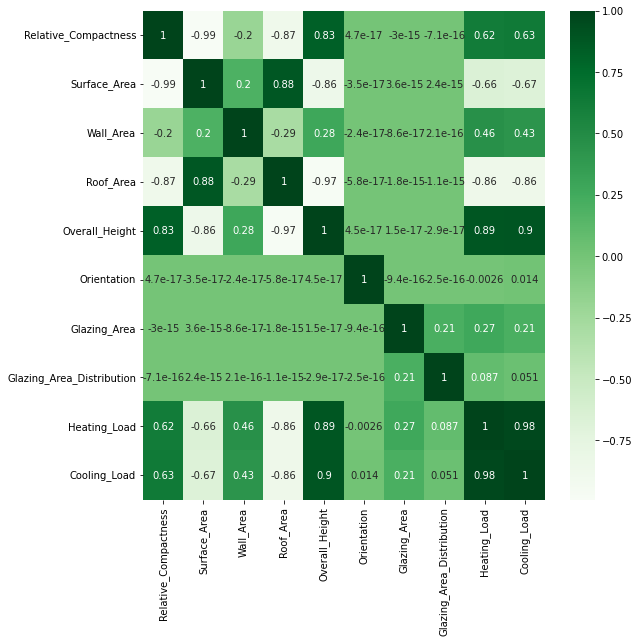

In [ ]:
# Preview correlation
plt.figure(figsize=(9,9))
sns.heatmap(data.corr(),annot=True, cmap='Greens')

In [ ]:
data_copy=data.copy()
A = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y=data_copy[['Heating_Load']] # This is the target feature in our problem
y_cool=data_copy[['Cooling_Load']]

Splitting data into training and test sets:

In [ ]:
A1,A2,y1,y2=train_test_split(A,y ,random_state=42, test_size=0.25, shuffle=True)

Normalizing the data:

In [ ]:
m=A.mean(axis=0)
s=A.std(axis=0)
my=y.mean()

A=(A-m)/s
y=y-my

m1=A1.mean(axis=0)
sA=A1.std(axis=0)
m2=y1.mean()

A1=(A1-m1)/sA
A2=(A2-m1)/sA
y1=y1-m2
y2=y2-m2

In [ ]:
n=A.shape[0]
n1=A1.shape[0]
n2=A2.shape[0]
d=A.shape[1]


A_mat=A.to_numpy()
y_mat=y.to_numpy().reshape(n)

A1_mat=A1.to_numpy()
y1_mat=y1.to_numpy().reshape(n1)

A2_mat=A2.to_numpy()
y2_mat=y2.to_numpy().reshape(n2)

Useful functions and classes (as they were used in Mr Clément W. Royer
 practical sessions):

In [ ]:
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [ ]:
# Stochastic gradient implementation
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=50,nb=1,with_replace=False,verbose=False): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)**t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 

        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

In [ ]:
#instantiating a regression problem
x_init = np.zeros(d)
lbda = 1. / n1 ** (0.5)
pblinreg = RegPb(A1_mat, y1_mat,lbda,loss='l2')
#Using L-BFGS-B algorithm to determine a solution
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

5.738346698440341
3.413267195540506e-10


***Question 2***

Gradient descent (l2 loss) with a small ridge penalty with different step sizes

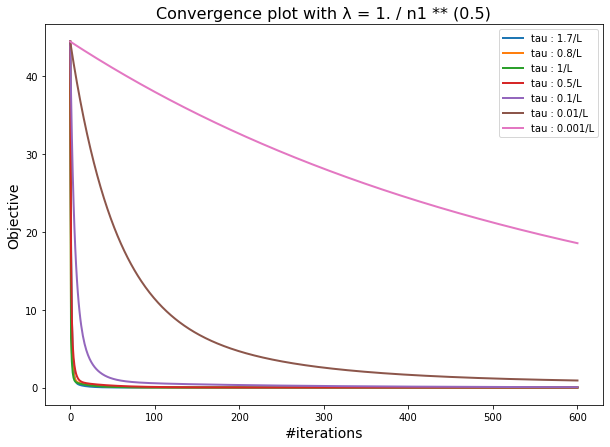

In [ ]:
nb_epochs = 600
n1 = pblinreg.n
nbset = n1
x0 = np.zeros(d)

valsstep0 = [1.7,0.8,1,0.5,0.1,0.01,0.001]
N = len(valsstep0)

plt.figure(figsize=(10, 7))
plt.set_cmap("RdPu")
plt.title("Convergence plot with λ = 1. / n1 ** (0.5)", fontsize=16)
for val in range(N):
    objs = np.zeros(n1)
    _, objs, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=valsstep0[val], n_iter=int(nb_epochs),nb=nbset,verbose=False)
    plt.plot(objs-f_min_lin, label="tau : "+str(valsstep0[val])+"/L", lw=2)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend(loc=1);

***Question 3***

The result obtained is coherent whith the theory; in fact, we can see that the fastest convergence corresponds to $\tau$ = 1/L where L is the Lipschitz constant.
So the optimal stepsize is 1/L.

***Question 4***

Gradient descent performance with different values of Ridge penalty

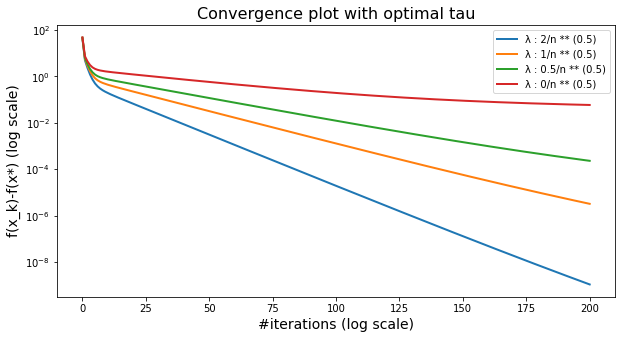

In [ ]:
nb_epochs = 600
x0 = np.zeros(d)
valslbda = [2,1,0.5,0]
N2 = len(valslbda)

plt.figure(figsize=(10, 5))
plt.set_cmap("RdPu")
plt.title("Convergence plot with optimal tau", fontsize=16)
x_init = np.zeros(d)
for val in range(N2):
    objs = np.zeros(n)
    lbda = valslbda[val] / n2 ** (0.5)
    pblinreg = RegPb(A2_mat, y2_mat,lbda,loss='l2')
    # Use L-BFGS-B to determine a solution for both problems
    # Compute the optimal solution for linear regression
    x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
    _, objs, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0,step0=1., n_iter=int(nb_epochs*n2/nbset),nb=n2,verbose=False)
    plt.semilogy(objs-f_min_lin, label="λ : "+str(valslbda[val])+"/n ** (0.5)", lw=2)
plt.xlabel("#iterations (log scale)", fontsize=14)
plt.ylabel("f(x_k)-f(x*) (log scale)", fontsize=14)
plt.legend(loc=1);



In [ ]:
nb_epochs = 600
x0 = np.zeros(d)
valslbda = [100,50,20,10,2,1,0.5,0]
N2 = len(valslbda)


x_init = np.zeros(d)
for val in range(N2):
    x_out = np.zeros(n)
    lbda = valslbda[val] / n1**(0.5)
    pblinreg_train = RegPb(A1_mat, y1_mat,lbda,loss='l2')
    pblinreg_test = RegPb(A2_mat, y2_mat,lbda,loss='l2')
    
    
    x_min_lin_train, f_min_lin, _ = fmin_l_bfgs_b(pblinreg_train.fun, x_init, pblinreg_train.grad, args=(), pgtol=1e-30, factr =1e-30)

    x_out, _ , _ = stoch_grad(x0,pblinreg_test,x_min_lin_train,stepchoice=0,step0=1, n_iter=int(nb_epochs),nb=n2,verbose=False)
    print(f'MSE on test set where ridge penalty equal to {lbda} is:',norm(A2_mat.dot(x_min_lin_train)-y2_mat)/n2)
    #print(f'MSE on test set with train_lambda {lbda}:',1/(2*n2) * norm(A2_mat.dot(x_out)-y2_mat)**2)
    #print(x_min_lin_train)
    


MSE on test set where ridge penalty equal to 4.166666666666667 is: 0.4976117397303022
MSE on test set where ridge penalty equal to 2.0833333333333335 is: 0.4087506321450358
MSE on test set where ridge penalty equal to 0.8333333333333334 is: 0.31623159776222154
MSE on test set where ridge penalty equal to 0.4166666666666667 is: 0.2759502785937108
MSE on test set where ridge penalty equal to 0.08333333333333333 is: 0.23817896985262998
MSE on test set where ridge penalty equal to 0.041666666666666664 is: 0.2292202295526753
MSE on test set where ridge penalty equal to 0.020833333333333332 is: 0.22309609493166963
MSE on test set where ridge penalty equal to 0.0 is: 0.21603075276083017
